# Week 4: Exploring Metro Micro Data and Age Mapping

This week, to progress in my coding experience and contribute to the group project, I will create a map of the Metro Micro zones and I will map the density of seniors by block group. 

## Age Data

In [1]:
#libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import fiona 
import numpy as np

## Building off of Week 3
This data cleaning analysis was part of last week's assignment. From here, my goal is to clip the county blocks down to the city level and figure out the population density of residents 65+ per square mile within each census block. 

In [2]:
df = pd.read_csv('age.csv')
df.head()

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A01001_004,SE_A01001_005,SE_A01001_006,SE_A01001_007,SE_A01001_008,SE_A01001_009,SE_A01001_010,SE_A01001_011,SE_A01001_012,SE_A01001_013
0,60014001001,"Block Group 1, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11947,NaN,NaN,NaN,...,243,57,98,221,111,395,228,214,116,67
1,60014001002,"Block Group 2, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11948,NaN,NaN,NaN,...,29,19,14,121,186,139,311,226,95,83
2,60014002001,"Block Group 1, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11949,NaN,NaN,NaN,...,52,32,31,115,125,117,123,232,70,17
3,60014002002,"Block Group 2, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11950,NaN,NaN,NaN,...,38,22,30,310,155,111,91,62,82,11
4,60014003001,"Block Group 1, Census Tract 4003, Alameda Coun...",ACSSF,ca,150,0,11951,NaN,NaN,NaN,...,41,37,39,225,147,173,137,141,67,0


# Fixing Geo_FIPS leading zero

This will allow us to join the data with the spatial block boundaries using a primary key. 

In [3]:
df.Geo_FIPS.head()

0    60014001001
1    60014001002
2    60014002001
3    60014002002
4    60014003001
Name: Geo_FIPS, dtype: int64

In [4]:
#specify geofips as a string

df = pd.read_csv('age.csv',
                 dtype = 
                 {
                     'Geo_FIPS':str,
                     'Geo_STATE':str, 
                     'Geo_COUNTY':str
                 }
                )

In [5]:
df.head()

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,...,SE_A01001_004,SE_A01001_005,SE_A01001_006,SE_A01001_007,SE_A01001_008,SE_A01001_009,SE_A01001_010,SE_A01001_011,SE_A01001_012,SE_A01001_013
0,060014001001,"Block Group 1, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11947,NaN,NaN,NaN,...,243,57,98,221,111,395,228,214,116,67
1,060014001002,"Block Group 2, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11948,NaN,NaN,NaN,...,29,19,14,121,186,139,311,226,95,83
2,060014002001,"Block Group 1, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11949,NaN,NaN,NaN,...,52,32,31,115,125,117,123,232,70,17
3,060014002002,"Block Group 2, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11950,NaN,NaN,NaN,...,38,22,30,310,155,111,91,62,82,11
4,060014003001,"Block Group 1, Census Tract 4003, Alameda Coun...",ACSSF,ca,150,0,11951,NaN,NaN,NaN,...,41,37,39,225,147,173,137,141,67,0


In [6]:
#confirming it changed to a string
df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25607 entries, 0 to 25606
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Geo_FIPS       25607 non-null  object 
 1   Geo_QName      25607 non-null  object 
 2   Geo_FILEID     25607 non-null  object 
 3   Geo_STUSAB     25607 non-null  object 
 4   Geo_SUMLEV     25607 non-null  int64  
 5   Geo_GEOCOMP    25607 non-null  int64  
 6   Geo_LOGRECNO   25607 non-null  int64  
 7   Geo_US         0 non-null      float64
 8   Geo_REGION     0 non-null      float64
 9   Geo_DIVISION   0 non-null      float64
 10  Geo_STATECE    0 non-null      float64
 11  Geo_STATE      25607 non-null  object 
 12  Geo_COUNTY     25607 non-null  object 
 13  Geo_COUSUB     0 non-null      float64
 14  Geo_PLACE      0 non-null      float64
 15  Geo_TRACT      25607 non-null  int64  
 16  Geo_BLKGRP     25607 non-null  int64  
 17  Geo_CONCIT     0 non-null      float64
 18  Geo_AI

# Deleting Null Columns

In [7]:
df.columns[df.isna().all()].tolist()

['Geo_US',
 'Geo_REGION',
 'Geo_DIVISION',
 'Geo_STATECE',
 'Geo_COUSUB',
 'Geo_PLACE',
 'Geo_CONCIT',
 'Geo_AIANHH',
 'Geo_AIANHHFP',
 'Geo_AIHHTLI',
 'Geo_AITSCE',
 'Geo_AITS',
 'Geo_ANRC',
 'Geo_CBSA',
 'Geo_CSA',
 'Geo_METDIV',
 'Geo_MACC',
 'Geo_MEMI',
 'Geo_NECTA',
 'Geo_CNECTA',
 'Geo_NECTADIV',
 'Geo_UA',
 'Geo_UACP',
 'Geo_CDCURR',
 'Geo_SLDU',
 'Geo_SLDL',
 'Geo_VTD',
 'Geo_ZCTA3',
 'Geo_ZCTA5',
 'Geo_SUBMCD',
 'Geo_SDELM',
 'Geo_SDSEC',
 'Geo_SDUNI',
 'Geo_UR',
 'Geo_PCI',
 'Geo_TAZ',
 'Geo_UGA',
 'Geo_PUMA5',
 'Geo_PUMA1',
 'Geo_BTTR',
 'Geo_BTBG',
 'Geo_PLACESE']

Hopefully this is true because there were 68 columns to start with? Use dropna to get rid of these

In [8]:
df = df.dropna(axis=1,how='all')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25607 entries, 0 to 25606
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Geo_FIPS       25607 non-null  object
 1   Geo_QName      25607 non-null  object
 2   Geo_FILEID     25607 non-null  object
 3   Geo_STUSAB     25607 non-null  object
 4   Geo_SUMLEV     25607 non-null  int64 
 5   Geo_GEOCOMP    25607 non-null  int64 
 6   Geo_LOGRECNO   25607 non-null  int64 
 7   Geo_STATE      25607 non-null  object
 8   Geo_COUNTY     25607 non-null  object
 9   Geo_TRACT      25607 non-null  int64 
 10  Geo_BLKGRP     25607 non-null  int64 
 11  Geo_GEOID      25607 non-null  object
 12  Geo_NAME       25607 non-null  object
 13  SE_A01001_001  25607 non-null  int64 
 14  SE_A01001_002  25607 non-null  int64 
 15  SE_A01001_003  25607 non-null  int64 
 16  SE_A01001_004  25607 non-null  int64 
 17  SE_A01001_005  25607 non-null  int64 
 18  SE_A01001_006  25607 non-n

25 non-null columns, most relate to age group

# Create a "Total" Column
We want a column of "totals" that is a sum of columns ending in 011, 012, and 013, because these represent the age groups (65+) that we are concerned with.

In [9]:
df['Total Senior Pop']=df.iloc[:,[23,24,25]].sum(axis=1)

In [10]:

df.head()

,Geo_FIPS,Geo_QName,Geo_FILEID,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_LOGRECNO,Geo_STATE,Geo_COUNTY,Geo_TRACT,...,SE_A01001_005,SE_A01001_006,SE_A01001_007,SE_A01001_008,SE_A01001_009,SE_A01001_010,SE_A01001_011,SE_A01001_012,SE_A01001_013,Total Senior Pop
0,060014001001,"Block Group 1, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11947,06,001,400100,...,57,98,221,111,395,228,214,116,67,397
1,060014001002,"Block Group 2, Census Tract 4001, Alameda Coun...",ACSSF,ca,150,0,11948,06,001,400100,...,19,14,121,186,139,311,226,95,83,404
2,060014002001,"Block Group 1, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11949,06,001,400200,...,32,31,115,125,117,123,232,70,17,319
3,060014002002,"Block Group 2, Census Tract 4002, Alameda Coun...",ACSSF,ca,150,0,11950,06,001,400200,...,22,30,310,155,111,91,62,82,11,155
4,060014003001,"Block Group 1, Census Tract 4003, Alameda Coun...",ACSSF,ca,150,0,11951,06,001,400300,...,37,39,225,147,173,137,141,67,0,208


# Which columns to keep?
Look at data dictionary and figure out which columns to keep. 

link to data dictionary: https://www.socialexplorer.com/data/ACS2021_5yr/metadata/?ds=SE

Only keep FIPS and the age groups we are interested in (65+), as well as the totals column 

In [11]:
columns_to_keep = ['Geo_FIPS',
                   'SE_A01001_001',
                   'SE_A01001_011',
                   'SE_A01001_012',
                   'SE_A01001_013',
                  'Total Senior Pop']
#save in a new dataframe
df2 = df[columns_to_keep]
df2.head()

,Geo_FIPS,SE_A01001_001,SE_A01001_011,SE_A01001_012,SE_A01001_013,Total Senior Pop
0,060014001001,1963,214,116,67,397
1,060014001002,1361,226,95,83,404
2,060014002001,1029,232,70,17,319
3,060014002002,1009,62,82,11,155
4,060014003001,1122,141,67,0,208


# Renaming Columns

In [12]:
columns = list(df2)
columns

['Geo_FIPS',
 'SE_A01001_001',
 'SE_A01001_011',
 'SE_A01001_012',
 'SE_A01001_013',
 'Total Senior Pop']

In [13]:
#copy and paste list above, replace vals with desired names
df2.columns = ['FIPS',
               'Total Pop',
               'Age 65-74',
               'Age 75-84', 
               'Age 85+', 
               'Total Senior Pop']
df2.sample(5)

,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop
9037,060375553003,706,159,39,130,328
11917,060590320112,867,111,52,0,163
11545,060570004013,2178,463,217,0,680
14389,060650425172,2156,57,80,11,148
13401,060590993112,1547,87,49,16,152


# Clipping

In [14]:
import geopandas as gpd

We want to clip the County boundaries down to just the City of LA. First, read a dataset of all the municipalities within LA county. 

In [15]:
cities=gpd.read_file('City_Boundaries.geojson')
cities.head()

,OBJECTID,CITY_NAME,CITY_LABEL,ABBR,OF_AREA_SM,CITY_TYPE,FEAT_TYPE,COLOR_EGIS,URL,PHONE,last_edited_date,ShapeSTArea,ShapeSTLength,geometry
0,3,Redondo Beach,Redondo Beach,RBCH,6.349,City,Breakwater,"Pink - RGB 255,190,232",www.redondo.org,3103721171,2022-07-20 00:08:28+00:00,2.483437e+05,7484.640344,"POLYGON ((-118.39951 33.84377, -118.39952 33.8..."
1,4,Long Beach,Long Beach,LB,50.309,City,Water,"Purple - RGB 185,185,250",www.longbeach.gov,5625706555,2022-07-20 00:08:28+00:00,4.000260e+06,20369.924519,"POLYGON ((-118.21061 33.72181, -118.21064 33.7..."
2,5,Redondo Beach,Redondo Beach,RBCH,6.349,City,Breakwater,"Pink - RGB 255,190,232",www.redondo.org,3103721171,2022-07-20 00:08:28+00:00,9.452611e+03,701.117043,"POLYGON ((-118.39150 33.83193, -118.39160 33.8..."
3,6,Los Angeles,Los Angeles,LA,468.852,City,Breakwater,"Gray - RGB 178,178,178",www.lacity.org,2134733231,2022-07-20 00:08:28+00:00,2.857692e+05,17391.983014,"POLYGON ((-118.26566 33.70405, -118.26574 33.7..."
4,7,Long Beach,Long Beach,LB,50.309,City,Breakwater,"Purple - RGB 185,185,250",www.longbeach.gov,5625706555,2022-07-20 00:08:28+00:00,1.097324e+05,5448.776853,"POLYGON ((-118.11850 33.74278, -118.11855 33.7..."


Query to subset just the City of LA. 

In [16]:
lacity=cities.query("CITY_NAME == 'Los Angeles'").copy()

Eventually, we want to join our census data to block groups within the City of LA. First, let's clip the block groups down to the City level, then we can join it to the census data. 

In [17]:
#finding a geojson file for census blocks 
blocks = gpd.read_file('Census_Block_Groups_2020.geojson')
blocks.head()

,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
0,1,1011101,101110,BG 1,4.814335e+06,8706.027651,"POLYGON ((-118.28497 34.25678, -118.28497 34.2..."
1,2,1011102,101110,BG 2,3.814445e+06,8807.809581,"POLYGON ((-118.29265 34.25957, -118.29319 34.2..."
2,3,1011103,101110,BG 3,3.666841e+06,8335.114480,"POLYGON ((-118.29134 34.25956, -118.29134 34.2..."
3,4,1011221,101122,BG 1,1.711345e+07,19507.471377,"POLYGON ((-118.29015 34.27417, -118.29015 34.2..."
4,5,1011222,101122,BG 2,1.134430e+07,19207.990424,"POLYGON ((-118.28528 34.26644, -118.28541 34.2..."


<AxesSubplot: >

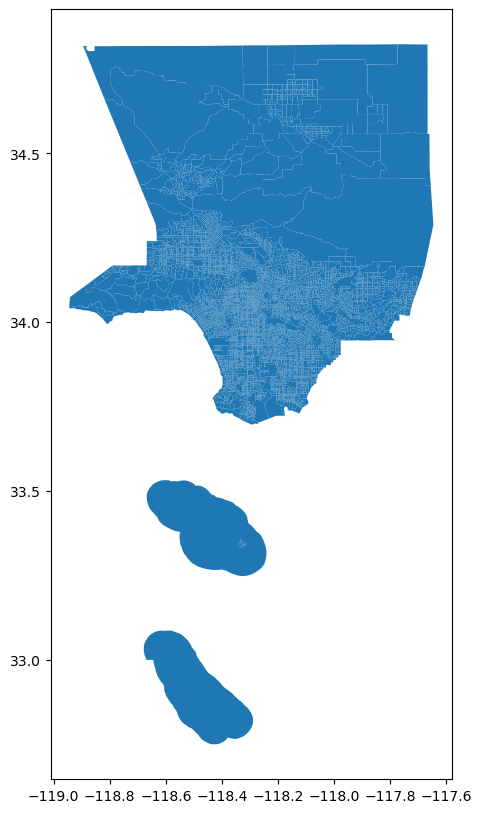

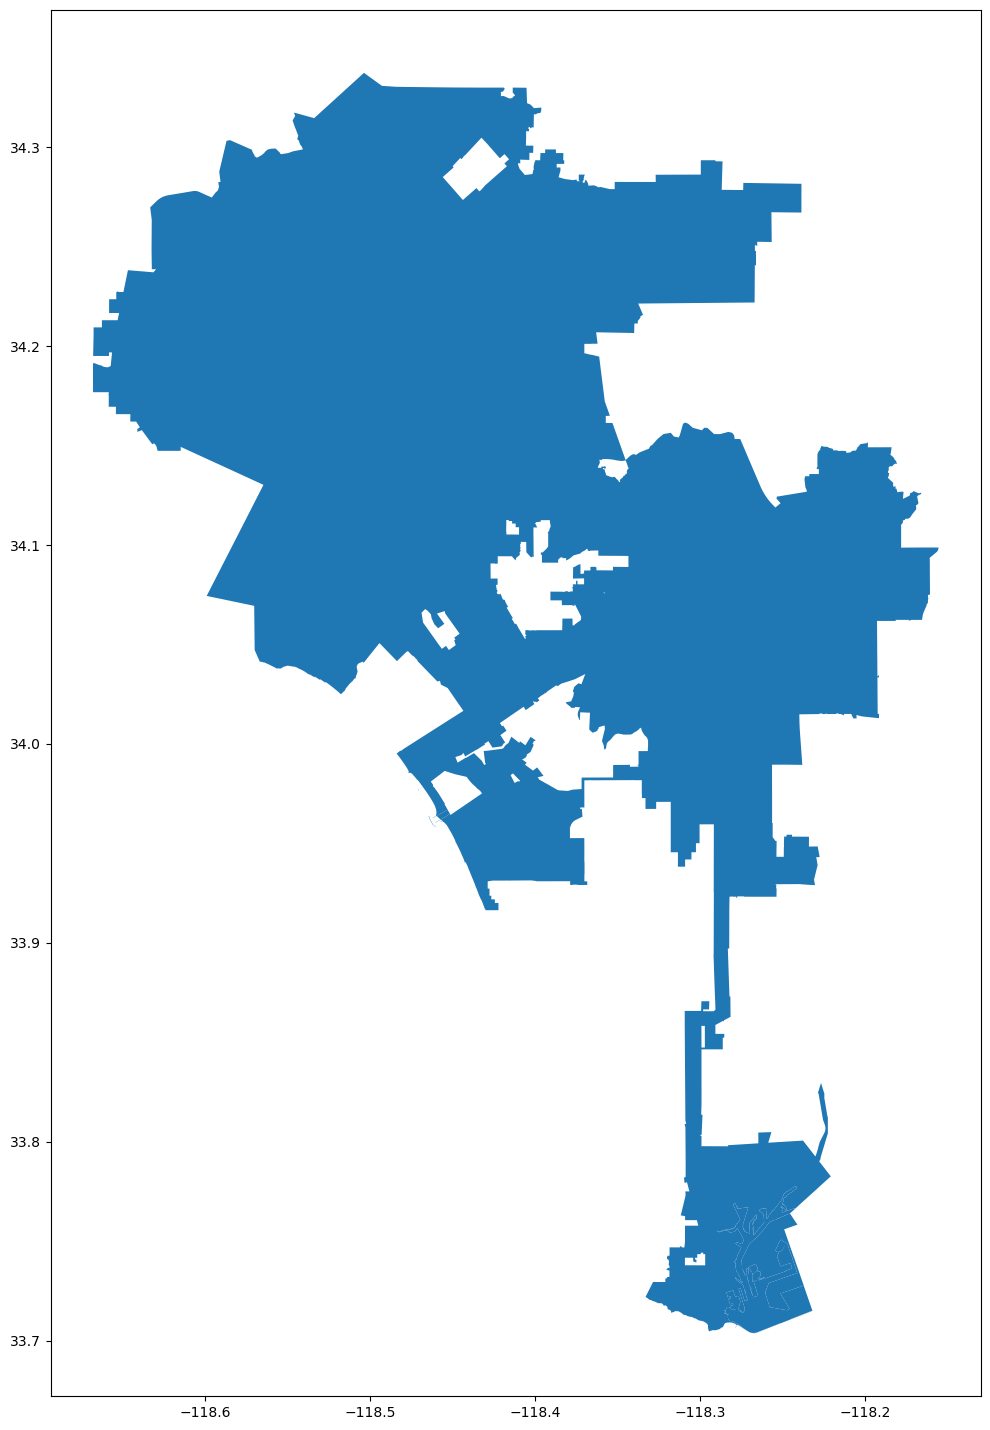

In [18]:
#plot them!
blocks.plot(figsize=(12,10))
lacity.plot(figsize=(12,20))

Clip the county down to the city boundary

In [19]:
blocks_clip = gpd.clip(blocks, lacity)
blocks_clip.head()

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


,OBJECTID,BG20,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry
2456,2457,2742023,274202,BG 3,1.045276e+06,4082.112116,"POLYGON ((-118.46464 33.97641, -118.46508 33.9..."
2449,2450,2739025,273902,BG 5,5.131686e+06,9166.983856,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713..."
2448,2449,2739024,273902,BG 4,1.861628e+06,6284.133027,"POLYGON ((-118.46565 33.97974, -118.46587 33.9..."
2447,2448,2739023,273902,BG 3,1.218168e+06,4851.582209,"POLYGON ((-118.46315 33.98615, -118.46310 33.9..."
2435,2436,2735023,273502,BG 3,4.868382e+06,10124.770714,"POLYGON ((-118.47672 33.98746, -118.47506 33.9..."


In [20]:
#subset only the columns we need (fips, area, and geometry)
blocks_clip = blocks_clip [['BG20', 'ShapeSTArea', 'geometry']]
blocks_clip.head()

,BG20,ShapeSTArea,geometry
2456,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9..."
2449,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713..."
2448,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9..."
2447,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9..."
2435,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9..."


Now we want to join the census block boundaries within the city of LA to our census data. 

In [21]:
# create a FIPS column
blocks_clip['FIPS'] ='06' + '037' + blocks_clip['BG20']

In [22]:
blocks_clip.head()
#ignore error!

,BG20,ShapeSTArea,geometry,FIPS
2456,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023
2449,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025
2448,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024
2447,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023
2435,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023


In [23]:
#join the ACS data with the geographic boundaries
blocks_age = blocks_clip.merge(df2,on="FIPS")

In [24]:
blocks_age.head()

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop
0,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023,740,0,0,13,13
1,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025,763,120,38,0,158
2,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024,998,90,10,0,100
3,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,1098,92,137,11,240
4,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023,923,29,40,0,69


## Creating columns for Area of Block Group and Population Density

We want to see how many seniors per square mile are in each block group. To do that, we have to figure out the square mile area of each block group. 
The column ShapeSTArea shows the area of each block group shape, but it is in units of square meters. To change this to square miles, we will divide each by [2,590,000](https://www.google.com/search?q=square+meters+to+square+miles&rlz=1C1CHBF_enUS878US878&oq=square&aqs=chrome.0.69i59j69i57j0i131i433i512j0i433i512j0i131i433i512l2j69i60l2.994j0j7&sourceid=chrome&ie=UTF-8)

In [25]:
blocks_age['Square Miles'] = blocks_age['ShapeSTArea']/2590000
blocks_age.head()

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Square Miles
0,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023,740,0,0,13,13,0.403581
1,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025,763,120,38,0,158,1.981346
2,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024,998,90,10,0,100,0.718775
3,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,1098,92,137,11,240,0.470335
4,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023,923,29,40,0,69,1.879684


Now, for population density: Divide the total senior pop by the square mile of the block

In [26]:
blocks_age['Senior Pop Density'] = round(blocks_age['Total Senior Pop']/blocks_age['Square Miles']) #rounding so we get whole numbers
blocks_age['Total Pop Density'] = round(blocks_age['Total Pop']/blocks_age['Square Miles']) #rounding so we get whole numbers
blocks_age.head()

,BG20,ShapeSTArea,geometry,FIPS,Total Pop,Age 65-74,Age 75-84,Age 85+,Total Senior Pop,Square Miles,Senior Pop Density,Total Pop Density
0,2742023,1.045276e+06,"POLYGON ((-118.46464 33.97641, -118.46508 33.9...",060372742023,740,0,0,13,13,0.403581,32.0,1834.0
1,2739025,5.131686e+06,"MULTIPOLYGON (((-118.47291 33.98356, -118.4713...",060372739025,763,120,38,0,158,1.981346,80.0,385.0
2,2739024,1.861628e+06,"POLYGON ((-118.46565 33.97974, -118.46587 33.9...",060372739024,998,90,10,0,100,0.718775,139.0,1388.0
3,2739023,1.218168e+06,"POLYGON ((-118.46315 33.98615, -118.46310 33.9...",060372739023,1098,92,137,11,240,0.470335,510.0,2335.0
4,2735023,4.868382e+06,"POLYGON ((-118.47672 33.98746, -118.47506 33.9...",060372735023,923,29,40,0,69,1.879684,37.0,491.0


# Testing Maps

KeyError: 'Pop Density'

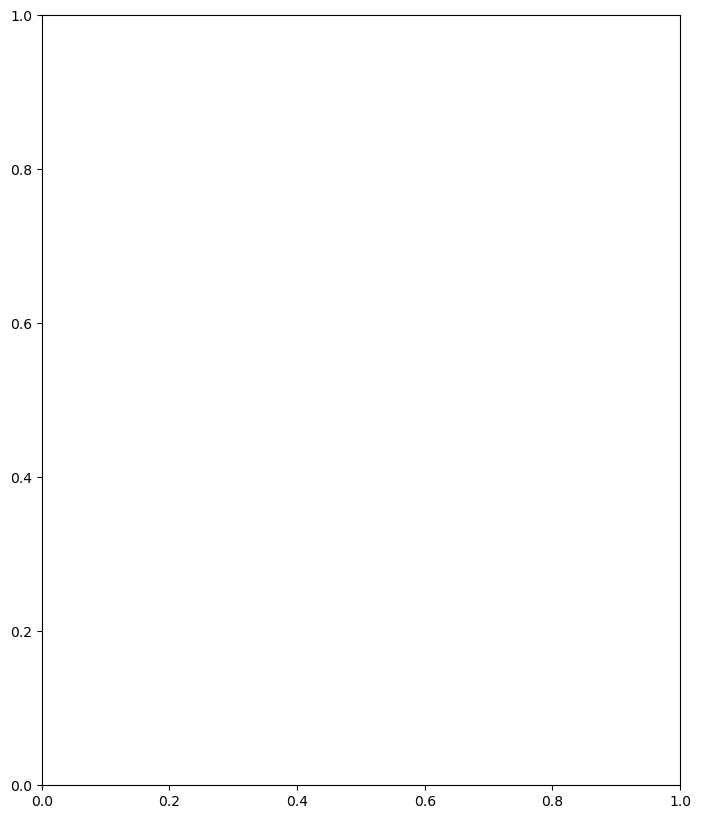

In [27]:
blocks_age.plot(figsize=(12,10),
                column='Pop Density',
                legend=True,
                scheme='NaturalBreaks')

In [ ]:
#try with equal interval
blocks_age.plot(figsize=(12,10),
                column='Pop Density',
                legend=True,
                scheme='equal_interval')


### These maps follow the trend of last week, that most block groups have few seniors with a few outliers. 

### Now we have maps of the number of seniors per square mile for each block group. 

In [ ]:
blocks_age.to_file('Pop_Density.geojson')

# Pivoting to Metro Micro Zones

In addition to overlays of Age data, we want to look at the existing "Metro Micro" zones. Metro Micro is a program in its introductory testing period. It is a local rideshare system that allows users to go wherever they want within designated zones on demand, for only $1. This service could improve grocery store access for seniors, and we want to try to figure out where the biggest need might be for another zone. 

The zones were found from the Metro Micro [site](https://micro.metro.net/), and were all available for download on Google Maps as kml files. The following cells involve creating a single dataframe of all zones. 

In [ ]:
#Importing each zone- mapped seperately on Metro Micro site
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

watts_compton = gpd.read_file('data/WattsCompton.kml',driver='KML')
elmonte = gpd.read_file('data/El Monte.kml',driver = 'KML')
highland = gpd.read_file('data/highland.kml',driver = 'KML')
lax=gpd.read_file('data/lax.kml',driver='KML')
noho=gpd.read_file('data/North HollywoodBurbank.kml',driver='KML')
sfv=gpd.read_file('data/sfv.kml',driver='KML')
ucla=gpd.read_file('data/uclawestwood.kml',driver='KML')
altadena=gpd.read_file('data/altadena.kml',driver='KML')

In [ ]:
#Combining them all vertically
micro = pd.concat([watts_compton, elmonte, highland, lax, noho, sfv, ucla, altadena],    # Combine vertically
                          ignore_index = True,
                          sort = False)
display(micro)

In [ ]:
#get rid of "Description" field 
desired_columns = ['Name', 'geometry']
micro_zones = micro[desired_columns]

micro_zones.columns = ['name', 'geometry'] #lowercase for continuity
display(micro_zones)

# Mapping

In [ ]:
micro_zones.plot()

## Contextily

In [ ]:
import contextily as ctx

#Trying to map with contextily
fig, ax = plt.subplots(figsize=(20,20))
micro.plot(ax=ax, 
        marker='X',
        markersize=10,
        color='none', 
          edgecolor = 'k',
          linewidth = 4)

# turn the axes off
ax.axis('off')

# give it a title
ax.set_title('LA Metro Micro Zones')
ctx.add_basemap(ax, crs=4326)

## Folium

In [ ]:
import folium

In [ ]:
m = folium.Map(location=[34.1,-118.3], 
               zoom_start = 10,
               tiles='CartoDB positron', 
               attribution='CartoDB')
#plot polygons
for _, r in micro_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)
m

In [ ]:
m.save('metromicro.html')